# Removing irrelevant images from webscraping with Yolov3

In [1]:
import cv2
import numpy as np
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import os

## Evaluating Yolov3 model through confusion matrix <br>
Yolov3 model was trained for 1000 iterations on Google Colab's GPU, giving us the weights found in "yolov3_training_final.weights". We then test the trained model and plot a confusion matrix as shown below.<br><br>
<b>Training dataset</b>: <i>yolo_labelled_images_final</i> => <u>100 labelled images (webscraped) containing carton boxes</u><br>
<b>Testing dataset</b>: <i>yolo_test_images_final</i> => <u>50 webscraped images with half-half split between relevant (w carton box) and irrelevant images (w/o carton box)</u>; <br>~Note: testing dataset and training dataset do not overlap. i.e. test set images do not contain training set images for fair testing

In [4]:
# testing the model by running it through a test dataset ("yolo_test_images_final") 

# Load Yolo
net = cv2.dnn.readNet("yolov3_training_final.weights", "yolov3_testing.cfg")

# Name custom object
classes = ["carton_box"]

# Images path
images_path = glob.glob(r"C:\Users\LeeX\Desktop\Proof_Of_Concept\yolo_test_images_final\*.jpg")

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

#1 means got box, 0 means no box
#based 
actual_y = [1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1]
predicted_y = []

# Insert here the path of your images
# random.shuffle(images_path)

# loop through all the images
for img_path in images_path:
    # Loading image
    img = cv2.imread(img_path)
    img = cv2.resize(img, None, fx=0.8, fy=0.8)
    height, width, channels = img.shape

    # creating a 4D blob + preprocessing (normalising images by rescaling 1/255 so pixel values range [0,1], swap colour channels, resize)
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    net.setInput(blob)  # sets the blob as the input of the network
    outs = net.forward(output_layers) # feed forward (inference) and get the network output

    # Showing information on the screen
    class_ids = []
    confidences = []
    boxes = []
    for out in outs: # loop over each of the layer outputs
        for detection in out: # loop over each of the object detection 
            # extract the label/class id and confidence (as a probability) of the current object detection 
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.3: # discard weak predictions by ensuring detected prob > min. prob which is set at 0.3 in this case
                # note that YOLO returns the centre (x,y) coordinates of the bounding box followed by the box's width and height
                # print('class_id:', class_id)
                #scaling the bounding box coordinates back relative to the size of the image
                center_x = int(detection[0] * width) 
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # deriving bottom and left corner coordinates of bounding box
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                # update list of bounding box coordinates, confidences, and class ids
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # perform non maximum suppression -> to select the most appropriate bounding box for the object
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    predicted_y.append(len(indexes)) # len(indexes) = 0 means no valid detection, len(indexes)>=1 means got valid detection
    
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)): # drawing rectangles on images with valid bounding box, i.e. confidence>0.3
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2) # draw a rectangle on the image
            cv2.putText(img, label, (x, y + 30), font, 1, color, 2) # put label text on the image


    cv2.imshow("Image", img)
    key = cv2.waitKey(1) # waitKey(1) will play the images continuously, while waitKey(0) will play still images that change upon pressing any key

cv2.destroyAllWindows() # close the window once all images finish displaying
print('predicted results: ',predicted_y)

predicted results:  [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]


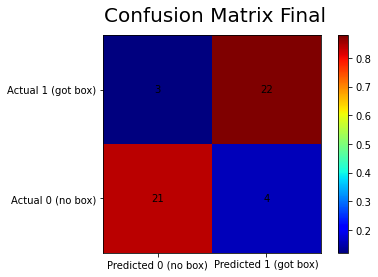

In [47]:
# plotting confusion matrix for results of testing yolov3_training_final.weights on yolo_test_images_final

false_negative = 0 # create counters for each of the 4 scenarios: FP,FN,TP,TN
false_positive = 0
true_negative = 0
true_positive = 0

for i in range(len(actual_y)):
    if actual_y[i]>=1 and predicted_y[i]>=1:# if actual y is 1 and predicted y is 1 => true positive
        true_positive+=1
    elif actual_y[i]>=1 and predicted_y[i]==0: # if actual y is 1 and predicted y is 0 => false negative
        false_negative+=1
    elif actual_y[i]==0 and predicted_y[i]==0: # if actual y is 0 and predicted y is 0 => true negative
        true_negative+=1
    elif actual_y[i]==0 and predicted_y[i]>=1: # if actual y is 0 and predicted y is 1 => false positive
        false_positive+=1

conf_arr = [[false_negative,true_positive], # this is the structure of the confusion matrix: FN at top left, FP at bottom right
            [true_negative,false_positive] 
            ]

norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)     # sum up the counts in each row, eg. FN + TP => this represents the total actual positive images
    for j in i:
        tmp_arr.append(float(j)/float(a)) # calculate the ratio 
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf() # clear previous figure (if any) to make way for new figure
fig.suptitle('Confusion Matrix Final', fontsize=20)
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = np.array(conf_arr).shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
x_axis_label = ['Predicted 0 (no box)','Predicted 1 (got box)']
y_axis_label = ['Actual 1 (got box)','Actual 0 (no box)']
plt.xticks(range(width), x_axis_label[:width])
plt.yticks(range(height), y_axis_label[:height])
plt.savefig('confusion_matrix_final.png', format='png')

##### Results of Testing
From the first row of the confusion matrix shown above, it can be seen that out of 25 images with carton boxes in it, the model was able to detect/predict the carton box in 22 of those images. This gives us a <b>true positive rate</b> of <u>22/25 = 88%</u>. There were 3 images which contained carton boxes but the model wrongly predicted that there were no carton boxes in them. This gives us a <b>false negative rate</b> of <u>3/25 = 12%</u>. <br><br>
From the second row, it can be seen that out of 25 images without carton boxes in it, the model correctly predicted/detected that there were no carton boxes for 21 of them. This gives us a <b>true negative rate</b> of <u>21/25 = 84%</u>. There were 4 images which did not contain carton boxes but the model wrongly predicted that there were carton boxes in them. This gives us a <b>false positive rate</b> of <u>4/25 = 16%</u>.<br><br>
Hence, the <b>overall accuracy rate</b> is <u>(21+22)/50 = 86%</u>.

In [69]:
print('Save location of confusion matrix image: ')
cwd = os.getcwd()
print(cwd)

# setting up directory for removing irrelevant scraped images in the next step
index_position = cwd.find('Proof_Of_Concept\\') + len('Proof_Of_Concept\\')
cwd = cwd[:index_position] 
cwd

Save location of confusion matrix image: 
C:\Users\LeeX\Desktop\Proof_Of_Concept\2c_train_yolo_to_clean_scraped_images\yolo_custom_detection


'C:\\Users\\LeeX\\Desktop\\Proof_Of_Concept\\'

## Applying Yolov3 model to clean webscraped images

In [70]:
# applying the model by running it through the folders containing webscraped images

# Load Yolo
net = cv2.dnn.readNet("yolov3_training_final.weights", "yolov3_testing.cfg")

# Name custom object
classes = ["carton_box"]

# Images path (will require some minor change in directory path)
images_path_bad = glob.glob(r"C:\Users\LeeX\Desktop\Proof_Of_Concept\good_bad_carton_images\webscraped_bad\*.jpg")
images_path_good = glob.glob(r"C:\Users\LeeX\Desktop\Proof_Of_Concept\good_bad_carton_images\webscraped_good\*.jpg")
images_path_list = [images_path_bad, images_path_good]

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

count = 0 # number of irrelevant images counter

# Insert here the path of your images
# random.shuffle(images_path)

# loop through all the images
for images_path in images_path_list:
    for img_path in images_path:
    # Loading image
        img = cv2.imread(img_path)
        img = cv2.resize(img, None, fx=0.8, fy=0.8)
        height, width, channels = img.shape

    # creating a 4D blob + preprocessing (normalising images by rescaling 1/255 so pixel values range [0,1], swap colour channels, resize)
        blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        net.setInput(blob)  # sets the blob as the input of the network
        outs = net.forward(output_layers) # feed forward (inference) and get the network output

    # Showing information on the screen
        class_ids = []
        confidences = []
        boxes = []
        for out in outs: # loop over each of the layer outputs
            for detection in out: # loop over each of the object detection 
            # extract the label/class id and confidence (as a probability) of the current object detection 
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.3: # discard weak predictions by ensuring detected prob > min. prob which is set at 0.3 in this case
                # note that YOLO returns the centre (x,y) coordinates of the bounding box followed by the box's width and height
                # print('class_id:', class_id)
                #scaling the bounding box coordinates back relative to the size of the image
                    center_x = int(detection[0] * width) 
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)

                # deriving bottom and left corner coordinates of bounding box
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                # update list of bounding box coordinates, confidences, and class ids
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        # perform non maximum suppression -> to select the most appropriate bounding box for the object
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

        if len(indexes)==0:
            os.remove(img_path)
            count += 1   

print('No. of irrelevant images removed: ',count)

No. of irrelevant images removed:  633
